In [1]:
%cd ..

/home/fedora/Jupyter/river-profiles


In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from tqdm.notebook import tqdm

import imageio as io
from PIL import Image

import time

# Stair function
The function $\nu$ should often look like:
$$
\nu(\tau, \chi) = 
\begin{cases}
\nu_0,\; \tau < \tau_0 \\
\nu_i,\; \tau_{i-1} < \tau < \tau_i, \; i = 1, ..., k-1\\
\nu_k,\; \tau > \tau_k
\end{cases}
$$
And we are going to work with this case.

In [3]:
def lengths_check(borders, values, raise_error=True):
    # Returns True, if lengths are correct: borders array should contain 1 element less, than values array
    # If this is not correct, it will raise error if raise_error or return Flase in other case.
    r = len(values) - len(borders) == 1
    if raise_error and not r:
        msg = f'Wrong arrays lengths: borders array should contain 1 element less, than values array. But their length are {len(borders)} and {len(values)}.'
        raise ValueError(msg)
        
    borders = np.array(borders)
    if (borders[1:] - borders[:-1] <= 0).any():
        warnings.warn("The borders array is not strictly increasing")
    return r

In [4]:
def stair_function(x, borders=[], values=[0]):
    """
    Parameters:
    -----------
    x : float or float array
        The argument of the function
    
    borders : list of floats len N
        The points, when the function changes the value
    
    values: list of floats len N+1
        values[0] corresponds to the function value before borders[0]
        values[i] corresponds to the function value between borders[i-1] and borders[i]
        
    Returns:
    --------
    r : float or float array shape x.shape
    """
    lengths_check(borders, values, raise_error=True)
    x = np.array(x)
    if x.shape == ():
        r = values[0]*np.ones(1)
    else:
        r = values[0]*np.ones(x.shape)
    for i in range(len(borders)):
        r[x >= borders[i]] = values[i+1]
    if x.shape == ():
        return r[0]
    return r

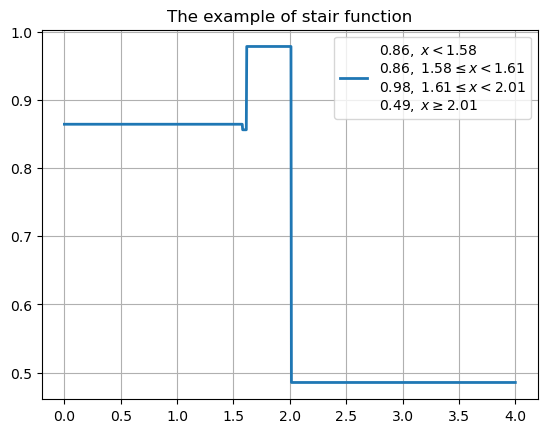

In [5]:
x0, x1 = 0, 4
n_stairs = 3
borders = x0 + (x1 - x0)*np.sort(np.random.random(n_stairs))
values = np.random.random(n_stairs + 1)

label = [r'${0:.2f}, \; {1:.2f} \leq x < {2:.2f}$'.format(values[i+1], 
                                                          borders[i], 
                                                          borders[i+1]) for i in range(n_stairs - 1)]
label = np.append(r'${0:.2f}, \; x < {1:.2f}$'.format(values[0], borders[0]), label)
label = np.append(label, r'${0:.2f}, \; x \geq {1:.2f}$'.format(values[-1], borders[-1]))
label = '\n'.join(label)

x = np.linspace(x0, x1, 1000)
y = stair_function(x, borders=borders, values=values)

plt.title('The example of stair function')
plt.plot(x, y, linewidth=2, label=label)
plt.legend()
plt.grid(True)
plt.show()

## Integral of stair function

For $\tau$ such that $\tau_i \leq \tau < \tau_{i+1}$ the integral of stair function $\nu$ will be:
$$
\int\limits_{\tau_0}^\tau \nu(t) dt = \sum\limits_{j=1}^i \nu_j(\tau_j - \tau_{j-1}) + \nu_{i+1}(\tau - \tau_i)
$$

In [6]:
def stair_integral(x0, x1, borders=[], values=[0], negative_backward=True):
    """
    """
    lengths_check(borders, values, raise_error=True)
    
    x1 = np.array(x1)
    x0 = x0*np.ones(x1.shape)
    
    borders_ = np.concatenate([[-np.inf], borders, [+np.inf]])
    
    ones = np.ones(np.append(len(borders_), x1.shape).astype(int))
    res = ones*borders_.reshape(np.append(len(borders_), np.ones(len(x1.shape))).astype(int))
    res[res < x0] = (x0*ones)[res < x0]
    res[res > x1] = (x1*ones)[res > x1]
    res = res[1:] - res[:-1]
    res = res*np.array(values).reshape(np.append(len(values), np.ones(len(res.shape) - 1)).astype(int))
    res = res.sum(axis=0)
    
    if negative_backward and (x0 > x1).any():
        res[x0 > x1] = -stair_integral(x0=x1[x0 > x1], x1=x0[x0 > x1], borders=borders, values=values)
        
    return res

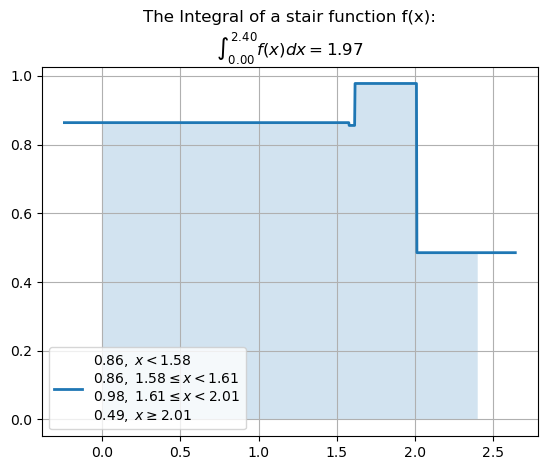

In [7]:
x0, x1 = 0, 2.4
int_val = stair_integral(x0, x1, borders=borders, values=values)

xl = np.append(x0, borders).min()
xr = np.append(x1, borders).max()
xl, xr = xl - 0.1*(xr - xl), xr + 0.1*(xr - xl)

x = np.linspace(xl, xr, 1000)
y = stair_function(x, borders=borders, values=values)

x_int = np.linspace(x0, x1, 1000)
y_int = stair_function(x_int, borders=borders, values=values)

title = 'The Integral of a stair function f(x):\n' 
title += r'$\int_{{{0:.2f}}}^{{{1:.2f}}} f(x) dx = {2:.2f}$'.format(x0, x1, int_val)

plt.title(title)
plt.plot(x, y, linewidth=2, label=label)
plt.fill_between(x_int, y_int, alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()

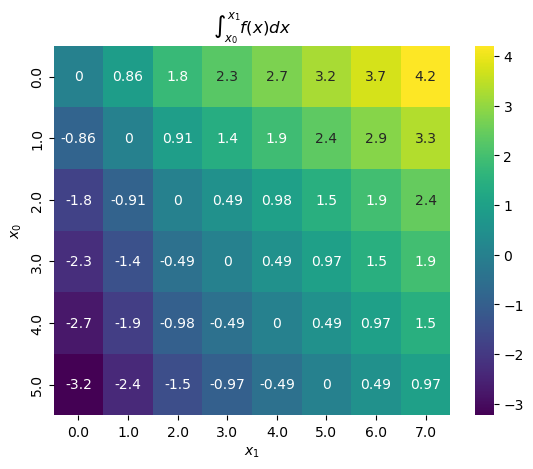

In [8]:
n = 6
m = 8
x0 = np.arange(n).reshape([n, 1])*np.ones([n, m])
x1 = np.arange(m).reshape([1, m])*np.ones([n, m])

int_vals = stair_integral(x0, x1, borders=borders, values=values)

plt.title(r'$\int_{x_0}^{x_1} f(x) dx$')
sns.heatmap(pd.DataFrame(int_vals, 
                         columns=pd.Index(x1[0], name='$x_1$'), 
                         index=pd.Index(x0[:, 0], name='$x_0$')), 
            annot=True, cmap='viridis')
plt.show()

# Define the slope patches

The slope patches are needed to understand the evolution of river profiles, given by formula
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^n = \nu(\tau, \chi)
$$
where the function $\nu$ is $\chi$-independent stair function:
$$
\nu(\tau, \chi) = \nu(\tau) = 
\begin{cases}
\nu_0, \; \tau_0 \le \tau < \tau_1 \\
\nu_1, \; \tau_1 \le \tau < \tau_2 \\
... \\
\nu_i, \; \tau_{i} \le \tau < \tau_{i+1} \\
... \\
\nu_N, \; \tau_N \le \tau < \infty \\
\end{cases}
$$
we can just say, that $\nu_{N+1} = \infty$.

The concept of slope patches is described in the [article](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/jgrf.20031) by Leigh Royden and J. Taylor Perron.


Let's redefine the slope patches.
Let it be $N$ periods $[\tau_0, \tau_1)$, $[\tau_1, \tau_2)$, ..., $[\tau_N, \infty)$.

The $i$-th slope patch should be a segment of solution of an equation, associated with period $[\tau_i, \tau_{i+1})$, corresponding uplift rate $\nu_i$ and the slope value $\sigma_i = \nu_i^{1/n}$.

Let $\tau$ be in $[\tau_{i-1}, \tau_{i})$. So the equation will be look like
$$
\cfrac{\partial\lambda}{\partial\chi} = \nu_{i-1}^{1/n} = \sigma_{i-1}
$$
There will be a solution for $\tau_i$:
$$
\lambda(\tau_i, \chi) = \sigma_{i-1}\chi
$$
but in the moment $\tau_i$ the uplift rate changes to $\nu_i$ and so the slope value changes to $\sigma_i = \nu_i^{1/n}$ and remains constant until the moment $\tau_{i+1}$.
__This results in a new steady state river segment at the downstream end of the river, while the slope patch generated between $\tau_{i-1}$ and $\tau_{i}$ continues to migrate upstream.__


## Patch Spatial Borders and Evaluation Values
The slope patch should is given by its borders. The right border is associated with the equation (B7) form the article by Leigh Royden and J. Taylor Perron:
$$
\chi_{R, i}(\tau) = n\nu_i^{(n - 1)/n} (\tau_i)
$$
If we suppose, that the first patch correspond the initial value, we should set $\chi_{R, 0} = +\infty$.

I'll realise right border $\chi_{R, i}$ caluculation in the `SlopePatches.get_rights` method.

To define left brders we can easily define the spatial length of patch by taking their right border in the maximal time moment corresponding to the patch:
$$
\Delta_i = \chi_{R, i}(\tau_{i+1}) = n\nu_i^{(n - 1)/n} (\tau_{i+1} - \tau_i)
$$
so the left border will be:
$$
\chi_{L, i}(\tau) = \chi_{R, i}(\tau) - \Delta_i
$$

I'll realise spatial patch length $\Delta_i$ in the `SlopePatches.get_lengths` method, and left border $\chi_{L, i}$ caluculation in the `SlopePatches.get_lefts` method.


The evaluation of the patch $i$ is given in the equation (B4) form the article by Leigh Royden and J. Taylor Perron:
$$
\lambda_i(\tau, \chi) = \chi\sigma_i + \int\limits_{\tau_i}^\tau [\nu(t) - \nu_i]dt
$$
where $\chi_{L, i} \le \chi < \chi_{R, i}$.

I'll reslise evaluation $\lambda_i(\tau, \chi)$ in the `SlopePatch.get_elevation` method.


## Neighbour patches Intersection
Let's find the intersections of lines, on which $i$-th and $(i+1)$-th patches lie. 
The first lat's denote
$$
x_0 = \chi_{R, i}, \;\;
x_2 = \chi_{L, i+1}
$$
$$
s_0 = \sigma_{i}, \;\;
s_2 = \sigma_{i+1}
$$
$$
y_0 = \lambda_{R, i} = \lambda_i(\tau, \chi_{R, i}) = \chi\sigma_i + \int\limits_{\tau_i}^\tau [\nu(t) - \nu_{i}]dt
$$
$$
y_2 = \lambda_{L, i+1} = \lambda_i(\tau, \chi_{L, i+1}) = \chi\sigma_{i+1} + \int\limits_{\tau_{i+1}}^\tau [\nu(t) - \nu_{i+1}]dt
$$

We should find $(x_1, y_1)$ which lies on intersection of patch  lines:
$$
\begin{cases}
y_1 = y_0 + s_0\cdot(x_1 - x_0) \\
y_1 = y_2 + s_2\cdot(x_1 - x_2)
\end{cases}
$$
and the point will be
$$
x_1 = \cfrac{y_0 - y_2 - s_0\cdot x_0 + s_2\cdot x_2}{s_2 - s_0}
$$
$$
y_1 = y_0 + s_0\cdot(x_1 - x_0)
$$

Now we can define the spatial position and elevation on intersection of $i$-th patch and $(i=1)$-th:
$$
\chi_{M, i} = \cfrac{1}{\sigma_{i+1} - \sigma_i}\left(\lambda_{R, i} - \lambda_{L, i+1} - \chi_{R, i}\cdot\sigma_{i} + \chi_{L, i+1}\cdot\sigma_{i+1}\right)
$$
$$
\lambda_{M, i} = \lambda_{R, i} + \sigma_i\cdot(\chi_{M, i} - \chi_{R, i})
$$

If the $i$-th patch translate faster, than $(i+1)$-th, then their intersection will be a __knick point__.

___Comment:__ $i$-th patch is the first, so I should use $\lambda_{R, i+1}$, $\lambda_{L, i}$, $\chi_{R, i+1}$, $\chi_{L, i}$._

I'll reslise finding the neighbour intersection $\chi_{M, i}(\tau), \lambda_{M, i}(\tau)$ in the `SlopePatch.get_neighbour_intersections` method.


## Neighbour Patches Connection
Let's connect a neigbour patches. We should connect points $(\chi_{R, i+1}, \lambda_{R, i=1})$ and $(\chi_{L, i}, \lambda_{L, i})$ by function $f(\chi)$ such that:
1. $f(\chi)$ is monotonic
2. $f(\chi_{R, i+1}) = \lambda_{R, i+1}$
3. $f(\chi_{L, i}) = \lambda_{L, i}$
4. $f\prime(\chi_{R, i+1}) = \sigma_{i+1}$
5. $f\prime(\chi_{L, i}) = \sigma_{i}$

Note that $\chi_{R, i+1} < \chi_{M, i}  < \chi_{L, i}$ if $i$-th patch patch moves faster, than $(i+1)$-th, or $\chi_{R, i+1} > \chi_{M, i} > \chi_{L, i}$ if $i$-th patch patch moves slower, than $(i+1)$-th.

Here is the solution by Leigh Royden and J. Taylor Perron given in equation (16b):
$$
\lambda = 
\cfrac{n-1}{n}\left(\cfrac{\chi^n}{n(\tau - \tau_{i+1})}\right)^{\cfrac{1}{n-1}} + 
(\tau - \tau_{i+1})\nu_{i+1} + 
\int\limits_{\tau_{i+1}}^\tau (\nu(t) - \nu_{i+1}) dt
$$
for $n \ne 1$ and $\chi\in(\chi_{R, i}, \chi_{L, i+1})$ or $\chi\in(\chi_{L, i+1}, \chi_{R, i})$.

I'll realise this in the `SlopePatch.get_neighbour_connections` method.

Taking the derivatives, we can check, this corresponds the equation:
$$
\cfrac{\partial\lambda}{\partial\tau} = 
-\left(\cfrac{\chi}{n(\tau - \tau_{i+1})}\right)^{\cfrac{n}{n-1}} + \nu(\tau)
$$
$$
\cfrac{\partial\lambda}{\partial\chi} = 
\left(\cfrac{\chi}{n(\tau - \tau_{i+1})}\right)^{\cfrac{1}{n-1}}
$$
so
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^n = \nu(\tau)
$$

This connection will be the part of river-profile in the case, when: $\tau > \tau_{i+1}$, $\chi_{R, i+1} < \chi_{L, i}$ and $\chi_{L, i+1} > \chi_{R, j}$ for all $j > i+1$.

## The Elevation
Generally, the elevation in point $\chi$ for moment $\tau$ should be
$$
\lambda(\tau, \chi)
\begin{cases}
\min \lambda_j(\tau, \chi), \; n \ge 1 \\
\max \lambda_j(\tau, \chi), \; n \le 1
\end{cases}
$$
where $\lambda_j(\tau, \chi)$ is from the set of functions, corresponing the elevation of patches or neighbour patch connections.

This should be realised in `get_elevation` method.

### Patches
The patch $i$ should correspond the solution for $\chi$ such that
$$
\max_{j > i} (\chi_{L, i}, \chi_{i\cup j}) < \chi < \min_{j < i} (\chi_{R, i}, \chi_{i\cup j})
$$
where $\chi_{i\cup j}$ is the point, where the lines conteining patches $i$ and $j$ intersects ($\chi_{i\cup j}$ has not value, if the lines are parallel). The intersextions can be find by `get_intersections_matrices`.

If there exist $\chi_{i\cup j} > \chi_{L, i}$, then $\chi_{i\cup j}$ can be a knick point. The similar is for $\chi_{i\cup j} < \chi_{R, i}$.

If
$$
\max_{j > i} (\chi_{L, i}, \chi_{i\cup j}) > \min_{j < i} (\chi_{R, i}, \chi_{i\cup j})
$$
the patch does not correspond the solution.

### Stretch Zones
The connection of neighbour patches $i$ and $i+1$ can be a stretch zone and correspond the solution, if they define the solution in their borders $\chi_{L, i}$ and $\chi_{R, i+1}$. So This is solution, if
$$
\chi_{L, i} \le \chi \le \chi_{R, i+1}
$$
$$
\chi_{L, i} \le \chi_{i\cup j} \; \forall j > i
$$
$$
\chi_{R, i+1} \ge \chi_{i+1\cup j} \; \forall j > i+1
$$

### Overlapses 
...

## Intersections for Calculating Knick Points
Knick point should be defined by the neighbour patches or neighbour patch connections. So there are 3 situations:
1. __2 patches intersect:__ In this case the knick point is just the point of intersection of 2 lines. It's can be find by `SlopePatches.get_neighbour_intersections` or `SlopePatches.get_intersections_matrices` methods.
2. __2 neighbour connections intersect:__ This is the intersection of 2 curves, defined by the equation (16b):
$$
\cfrac{n-1}{n}\left(\cfrac{\chi^n}{n(\tau - \tau_{j+1})}\right)^{\frac{1}{n-1}} + 
(\tau - \tau_{j+1})\nu_{j+1} + 
\int\limits_{\tau_{j+1}}^\tau (\nu(t) - \nu_{j+1}) dt = 
\cfrac{n-1}{n}\left(\cfrac{\chi^n}{n(\tau - \tau_{k+1})}\right)^{\frac{1}{n-1}} + 
(\tau - \tau_{k+1})\nu_{k+1} + 
\int\limits_{\tau_{k+1}}^\tau (\nu(t) - \nu_{k+1}) dt
$$
we can represent this as
$$
a_j\chi^{\frac{n}{n-1}} + b_j = 
a_k\chi^{\frac{n}{n-1}} + b_k
$$
where
$$
a_i = \cfrac{n-1}{n}\left(n(\tau - \tau_{i+1})\right)^{-\frac{1}{n-1}}
$$
$$
b_i = (\tau - \tau_{i+1})\nu_{i+1} + 
\int\limits_{\tau_{i+1}}^\tau (\nu(t) - \nu_{i+1}) dt
$$
and we can find the spatial position $\chi$ of the curves intersection as
$$
\chi = \left(\cfrac{b_k - b_j}{a_j - a_k}\right)^{\frac{n-1}{n}}
$$

3. __Patch intersects neighbour connection:__ 
The $j$-th patch elevation at the moment of $\tau$ is given by the equation:
$$
\lambda_j(\chi) = \chi\sigma_j + \int\limits_{\tau_j}^\tau [\nu(t) - \nu_j] dt
$$
and this can be written as
$$
\lambda_j(\chi) = c\chi + d
$$
where
$$
c = \sigma_j = \nu_j^{1/n}
$$
$$
d = \int\limits_{\tau_j}^\tau [\nu(t) - \nu_j] dt
$$
And the $k$-th neighbour patches connections elevation at the moment of $\tau$ is given by the equation:
$$
\lambda_k(\chi) = \cfrac{n-1}{n}\left(\cfrac{\chi^n}{n(\tau - \tau_{k+1})}\right)^{\frac{1}{n - 1}} + (\tau - \tau_{k+1})\nu_{k+1} + \int\limits_{\tau_{k+1}}^\tau [\nu(t) - \nu_{k+1}] dt
$$
and this also can be written as
$$
\lambda_k(\chi) = a\chi^{\frac{n}{n-1}} + b
$$
where
$$
a = \cfrac{n-1}{n}\left(n(\tau - \tau_{k+1})\right)^{-\frac{1}{n-1}}
$$
$$
b = (\tau - \tau_{k+1})\nu_{k+1} + \int\limits_{\tau_{k+1}}^\tau [\nu(t) - \nu_{k+1}] dt
$$
Those patch and neighbour connection intersect in $\chi$ such that $f(\chi) = \lambda_k(\chi) - \lambda_j(\chi) = 0$
$$
f(\chi) = a\chi^{\frac{n}{n-1}} + b - c\chi - d
$$
This is nonlinear equation, so we can solve this using methods like [Newton](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html#scipy.optimize.newton) or any other.

We are interesting in cases, when patches and neighbour connections inresect in their domain: higher than maximum of pair left borders, and less than minimum of their right borders borders. That means, that the $f(chi)$ is monotonic on that, and $f$ has different signs on brders, so methods like [bisection](https://en.wikipedia.org/wiki/Bisection_method) or [ridder](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.ridder.html#scipy.optimize.ridder) can be used.

I'll youse bisection method, cause it can wark with any fuction values on the borders.

In [9]:
def solve_bisect(f, x0, x1, eps=1e-8, max_iter=100, iteration=0):
    """
    Bisection recursive solve method
    https://en.wikipedia.org/wiki/Bisection_method
    
    Parameters:
    -----------
    f : function, takes float or np.array as argument
    
    x0, x1: float or np.array same shape, as f-argument should be
    
    eps: float
        Accuracy
    
    max_iter: int
        Maximal number of iterations
    
    iteration : int
        Iteration number
    
    Returns:
    --------
    float or np.array same shape, as x0 and x1
    """
    x0 = np.array(x0)
    x1 = np.array(x1)
    if (np.sign(f(x0))*np.sign(f(x1)) > 0).any():
        msg = 'f(x0) and f(x1) should have different signs.'
        raise ValueError(msg)
    xm = 0.5*(x0 + x1)
    change0 = np.sign(f(x0)) == np.sign(f(xm))
    change1 = np.sign(f(x1)) == np.sign(f(xm))
    x0[change0] = xm[change0]
    x1[change1] = xm[change1]
    if (abs(x0 - x1)[np.invert(np.isnan(x0 - x1))] < eps).all() or (iteration == max_iter):
        return xm
    return solve_bisect(f, x0, x1, eps=eps, max_iter=max_iter, iteration=iteration + 1)

In [10]:
f = lambda x: 2*np.cos(x - 0.5*np.pi) + 3*x**3
x0 = +np.pi/2*np.linspace(0.1, 0.9, 10) - 0.1
x1 = -np.pi/2*np.linspace(0.1, 0.9, 10) 
x0 = np.append(x0, 1.7)
x1 = np.append(x1, np.nan)

x = solve_bisect(f, x0, x1)

pd.DataFrame({'x0': x0, 'x1': x1, 'x': x, 'f(x)': f(x)})

,x0,x1,x,f(x)
0,0.057080,-0.157080,3.026235e-10,6.052471e-10
1,0.196706,-0.296706,-1.863576e-10,-3.727151e-10
2,0.336332,-0.436332,5.129108e-10,1.025822e-09
3,0.475959,-0.575959,1.463914e-09,2.927829e-09
4,0.615585,-0.715585,-1.803810e-09,-3.607620e-09
5,0.755211,-0.855211,-2.215905e-09,-4.431811e-09
6,0.894838,-0.994838,2.489008e-09,4.978015e-09
7,1.034464,-1.134464,-1.678419e-09,-3.356838e-09
8,1.174090,-1.274090,-1.165246e-09,-2.330492e-09
9,1.313717,-1.413717,-3.052992e-09,-6.105984e-09


In [11]:
class SlopePatches:
    def __init__(self, patch_starts, uplift_rates, n):
        """
        Atributes:
        ----------
        patch_starts - float array length N > 0 (let N be the number of patches; It's not used in code itself)
            The times tau_i, when i-th patch starts
        
        uplift_rates - float array length N
            The values nu_i, uplift rate of the i-th patch (correspondes tau between tau_i and tau_{i+1})
        
        n - float
            The exponent on channel slope
        """
        if len(patch_starts) == 0:
            raise ValueError('The patch_starts should be not empty.')
        if len(patch_starts) != len(uplift_rates):
            msg = 'The arrays patch_starts and uplift_rates should be the same length. But:'
            msg += f'\nlen(patch_starts) = {len(patch_starts)}\nlen(uplift_rates) = {len(uplift_rates)}'
            raise ValueError(msg)
            
        self.patch_starts = np.array(patch_starts)
        self.uplift_rates = np.array(uplift_rates)
        self.n = float(n)
        
    
    def count(self):
        # returns the number of patches N
        return len(self.patch_starts)
    
    
    def get_slopes(self):
        # Returns the array of slopes for each patch; 
        # Associated with the equation (10) form the article by Leigh Royden and J. Taylor Perron
        return self.uplift_rates**(1/self.n)
    
    
    def get_rights(self, tau, first_is_infinite=True):
        """
        Returns the right spatial borders of the patches for time moments tau.  
        Associated with the equation (B7) form the article by Leigh Royden and J. Taylor Perron
        
        Comment:
        --------
        It's nan for moments tau less than patch starts
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        first_is_infinite : bool, default True
            If it's True, the first patch right border will be at infinite
            If it's False, it will be defined proportional to the moment tau
            
        Returns:
        --------
        res: float array shape (N, tau.shape)
            Right borders for each patch and each moment tau
        """
        tau = np.array(tau)
        
        shape_res = np.append(self.count(), tau.shape).astype(int)
        shape_rat = shape_res.copy()
        shape_rat[1:] = 1
        shape_tau = shape_res.copy()
        shape_tau[0] = 1
        
        tau_use = tau.reshape(shape_tau)
        tau_use = tau_use - self.patch_starts.reshape(shape_rat)
        tau_use[tau_use < 0] = np.nan
        
        res = self.n*self.uplift_rates.reshape(shape_rat)**((self.n - 1)/self.n)*tau_use
        if first_is_infinite:
            res[0] = np.inf
        return res
    
    
    def get_lengths(self):
        """
        Returns the spatial lengths of patch.
        It's defined as the product of time lengths of patches and their translation speed
        """
        res = self.n*self.uplift_rates**((self.n - 1)/self.n) 
        res *= np.append((self.patch_starts[1:] - self.patch_starts[:-1]), np.inf)
        return res
    
    
    def get_lefts(self, tau):
        """
        Returns the right spatial borders of the patches for time moments tau.
        It's defune as subtraction of patch right (noninfinite) borders and their lengths
        
        Comment:
        --------
        It's nan for moments tau less than patch starts
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        Returns:
        --------
        res: float array shape (N, tau.shape)
            Left borders for each patch and each moment tau
        """
        tau = np.array(tau)
        
        rights = self.get_rights(tau, first_is_infinite=False)
        lengths = self.get_lengths()
        
        shape_res = np.array(rights.shape)
        shape_len = shape_res.copy()
        shape_len[1:] = 1
        
        res = rights - lengths.reshape(shape_len)
        res[res < 0] = 0
        return res
    
    
    def get_uplift_rate(self, tau, chi=np.nan, rate_before=np.nan):
        """
        Returns the upluft rate (nu-value) for each moment tau.
        
        Parameters:
        -----------
        tau : float or float array
            The time argument of the uplift rate function
        
        chi : float or float array
            The spatial argument of the uplift rate function
            The result value should not depend on this argument, 
            but sometimes this function should take 2 paraeters.
        
        rate_before: float
            The uplift rate before the first patch starts
        
        Returns:
        --------
        res : float or float array
            The uplift rates for moments tau
        """
        tau = np.array(tau)
        chi = np.array(chi)
        if tau.ndim > chi.ndim:
            use_shape = tau.shape
        else:
            use_shape = chi.shape
            
        res = stair_function(tau, borders=self.patch_starts, values=np.append(rate_before, self.uplift_rates))
        res = np.ones(use_shape)*res
        return res
    
    
    def get_elevations_for_patches(self, tau, chi):
        """
        Returns the elevation for each patch for moments tau in spatial points chi
        Associated with the equation (B4) form the article by Leigh Royden and J. Taylor Perron
        
        Comment:
        --------
        It's nan in the case, if the point (tau, chi) do not correspond the patch.
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        chi : float or float array
            The (dimensionless) distance argument
            tau and chi should be the same shape
        
        Returns:
        --------
        lam : float array shape (N, tau/chi.shape)
            The elevation throught the time moments tau, spatial points chi for each patch
        """
        tau = np.array(tau)
        chi = np.array(chi)
        
        chi_left = self.get_lefts(tau)
        chi_right = self.get_rights(tau)
        chi_use = chi*np.ones(np.append(self.count(), chi.shape))
        chi_use[chi_use < chi_left] = np.nan
        chi_use[chi_use > chi_right] = np.nan
        chi_use[np.isnan(chi_left)] = np.nan
        chi_use[np.isnan(chi_right)] = np.nan
        
        lam_prechi = chi_use*self.get_slopes().reshape(np.append(self.count(), np.ones(chi.ndim, dtype=int)))
        
        lam_pretau = np.zeros(lam_prechi.shape)
        for i in range(self.count()):
            stair_values = np.append(0, self.uplift_rates - self.uplift_rates[i])
            lam_pretau[i] = stair_integral(x0=self.patch_starts[i], 
                                           x1=tau, 
                                           borders=self.patch_starts, 
                                           values=stair_values)
        lam = lam_prechi + lam_pretau
        return lam
    
    
    def get_right_elevations(self, tau, first_is_infinite=True):
        """
        Returns elevations pon the right borders of the patches for time moments tau.  
        Associated with the equation (B7) form the article by Leigh Royden and J. Taylor Perron
        
        Comment:
        --------
        It's nan for moments tau less than patch starts
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        first_is_infinite : bool, default True
            If it's True, the first patch right border will be at infinite
            If it's False, it will be defined proportional to the moment tau
            
        Returns:
        --------
        lam: float array shape (N, tau.shape)
            Elevations on the right borders for each patch and each moment tau
        """
        tau = np.array(tau)
        chi = self.get_rights(tau, first_is_infinite=first_is_infinite)
        
        lam_prechi = np.array([chi[i]*s for i, s in enumerate(self.get_slopes())])
        lam_pretau = np.zeros(lam_prechi.shape)
        for i in range(self.count()):
            stair_values = np.append(0, self.uplift_rates - self.uplift_rates[i])
            lam_pretau[i] = stair_integral(x0=self.patch_starts[i], 
                                           x1=tau, 
                                           borders=self.patch_starts, 
                                           values=stair_values)
        lam = lam_prechi + lam_pretau
        return lam
    
    
    def get_left_elevations(self, tau):
        """
        Returns elevations on the left borders of the patches for time moments tau.  
        Associated with the equation (B7) form the article by Leigh Royden and J. Taylor Perron
        
        Comment:
        --------
        It's nan for moments tau less than patch starts
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        Returns:
        --------
        lam: float array shape (N, tau.shape)
            Elevations on the left borders for each patch and each moment tau
        """
        tau = np.array(tau)
        chi = self.get_lefts(tau)
        
        lam_prechi = np.array([chi[i]*s for i, s in enumerate(self.get_slopes())])
        lam_pretau = np.zeros(lam_prechi.shape)
        for i in range(self.count()):
            stair_values = np.append(0, self.uplift_rates - self.uplift_rates[i])
            lam_pretau[i] = stair_integral(x0=self.patch_starts[i], 
                                           x1=tau, 
                                           borders=self.patch_starts, 
                                           values=stair_values)
        lam = lam_prechi + lam_pretau
        return lam
    
    
    def get_neighbour_intersections(self, tau):
        """
        Returns the spatial position and elevation of intersections between neighbours patches
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        Returns:
        --------
        chi1 : float arrray shape(N-1, tau.shape)
            THe spatial positions of intersection between i-th and (i+1) patches for time moments tau
            
        lam1 : float arrray shape(N-1, tau.shape)
            THe elevations of intersection between i-th and (i+1) patches for time moments tau
        """
        chi0 = self.get_lefts(tau)[:-1]
        chi2 = self.get_rights(tau)[1:]
        lam0 = self.get_left_elevations(tau)[:-1]
        lam2 = self.get_right_elevations(tau)[1:]
        slopes0 = self.get_slopes()[:-1]
        slopes2 = self.get_slopes()[1:]
        
        slopes_shape = np.ones(chi0.ndim, dtype=int)
        slopes_shape[0] = self.count() - 1
        slopes0 = slopes0.reshape(slopes_shape)
        slopes2 = slopes2.reshape(slopes_shape)
        
        chi1 = (lam0 - lam2 - chi0*slopes0 + chi2*slopes2)/(slopes2 - slopes0)
        lam1 = lam0 + (chi1 - chi0)*slopes0 
        return chi1, lam1
    
    
    def get_neighbour_connections(self, tau, chi):
        """
        Returns the elevation over connection between i-th and (i+1)-th slope patches.
        This is stretch zones or consuming knick points
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        chi : float or float array
            The (dimensionless) distance argument
            tau and chi should be the same shape
        
        Returns:
        --------
        lam: float array shape (N-1, tau/chi.shape)
            The elevation over connection between i-th and (i+1)-th slope patches;
            Stretch zones or consuming knick points
        """
        if self.n == 1:
            # here I returns nans matrix, but maybe its better to return right lams when chi is equal
            # lam = np.nans*np.ones(shape); lam[chi1 == chi] = lam1[chi1 == chi]; return lam
            if tau.ndim > chi.ndim:
                shape = tau.shape
            else:
                shape = chi.shape
            shape = np.append(self.count() - 1, shape)
            return np.nan*np.ones(shape)
        chi0 = self.get_lefts(tau)[:-1]
        chi1 = self.get_rights(tau)[1:]
        lam0 = self.get_left_elevations(tau)[:-1]
        lam1 = self.get_right_elevations(tau)[1:]
        
        chi_min = np.array([chi0, chi1]).min(axis=0)
        chi_max = np.array([chi0, chi1]).max(axis=0)
        chi = np.ones(chi0.shape)*chi
        chi[np.isnan(chi0)] = np.nan
        chi[np.isnan(chi1)] = np.nan
        chi[chi < chi_min] = np.nan
        chi[chi > chi_max] = np.nan
        chi[chi_min == chi_max] = np.nan
        
        
        tau1_shape = np.ones(chi1.ndim, dtype=int)
        tau1_shape[0] = self.count() - 1
        tau1 = self.patch_starts[1:].reshape(tau1_shape)
        
        # equation 16b
        lam = (self.n - 1)/self.n*(chi**self.n/(tau - tau1)/self.n)**(1/(self.n - 1))
        lam += (tau - tau1)*self.uplift_rates[1:].reshape(tau1_shape)
        for i in range(self.count() - 1):
            stair_values = np.append(0, self.uplift_rates - self.uplift_rates[i + 1])
            lam[i] += stair_integral(x0=self.patch_starts[i + 1], 
                                     x1=tau, 
                                     borders=self.patch_starts, 
                                     values=stair_values)
        return lam
    
    
    def get_elevation(self, tau, chi):
        """
        Returns the elevation
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        chi : float or float array
            The (dimensionless) distance argument
            tau and chi should be the same shape
        
        Returns:
        --------
        lam: float array shape  tau/chi.shape
            The elevation
        """
        lam = np.concatenate([self.get_elevations_for_patches(tau, chi), 
                              self.get_neighbour_connections(tau, chi)], axis=0)
        if self.n < 1:
            lam[np.isnan(lam)] = -np.inf
            lam = lam.max(axis=0)
        else:
            lam[np.isnan(lam)] = +np.inf
            lam = lam.min(axis=0)
        return lam
    
    
    def get_intersection_matrices_of_patches(self, tau, filter_with_borders=False):
        """
        Returns the spatial position of intersections between patches
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        filter_with_borders: bool
            If True, filter the result, s.t. intersection be in borders
        Returns:
        --------
        chi1 : float arrray shape (N, N, tau.shape)
            The matrices of spatial positions of intersection  for time moments tau
            The element [i, j] corresponds the intersection between i-th and j-th patches
        """
        shape = np.concatenate([[self.count(), self.count()], tau.shape])
        shape0 = np.ones(len(shape), dtype=int)
        shape2 = np.ones(len(shape), dtype=int)
        shape0[0], shape2[1] = self.count(), self.count()
        permutation = np.arange(len(shape), dtype=int)
        permutation[:2] = [1, 0]
        
        chi0 = np.transpose(self.get_lefts(tau)*np.ones(shape), axes=permutation)
        chi2 = self.get_rights(tau, first_is_infinite=False)*np.ones(shape)
        lam0 = np.transpose(self.get_left_elevations(tau)*np.ones(shape), axes=permutation)
        lam2 = self.get_right_elevations(tau, first_is_infinite=False)*np.ones(shape)
        slopes0 = self.get_slopes().reshape(shape0)*np.ones(shape)
        slopes2 = self.get_slopes().reshape(shape2)*np.ones(shape)
        
        cond = slopes0 != slopes2
        
        chi1 = np.nan*np.ones(shape)
        chi1[cond] = (lam0[cond] - lam2[cond] - chi0[cond]*slopes0[cond] + chi2[cond]*slopes2[cond])/(slopes2[cond] - slopes0[cond])
        #lam1 = lam0 + (chi1 - chi0)*slopes0 
        #return chi1, lam1
        
        # Здесь какая-то проблема, не все значения нанятся симметрично, и некоторые нанятся излишне
        # Видмо, в get_intersection_matrices_of_patches_and_neighbour_connections что-то схожее
        if filter_with_borders: 
            lefts = self.get_lefts(tau).reshape(self.count(), 1, *tau.shape)
            rights = self.get_rights(tau).reshape(self.count(), 1, *tau.shape)
            chi1[chi1 < lefts] = np.nan
            chi1[chi1 > rights] = np.nan
            lefts = np.swapaxes(lefts, 0, 1)
            rights = np.swapaxes(rights, 0, 1)
            chi1[chi1 < lefts] = np.nan
            chi1[chi1 > rights] = np.nan
        return chi1
    
    
    def get_intersection_matrices_of_neighbour_connections(self, tau, filter_with_borders=True):
        """
        Returns the spatial position of intersections between neighbour connections
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        filter_with_borders: bool
            If True, filter the result, s.t. intersection be in borders
            
        Returns:
        --------
        chi : float arrray shape (N - 1, N - 1, tau.shape)
            The matrices of spatial positions of intersection  for time moments tau
            The element [i, j] corresponds the intersection between i-th and j-th neighbour connection
        """
        tau = np.array(tau)
        shape = np.concatenate([(self.count() - 1, self.count() - 1), tau.shape]).astype(int)
        if self.n == 1:
            return np.nan*np.ones(shape)
        
        start_matrix_j = self.patch_starts[1:]*np.ones([self.count() - 1, self.count() - 1])
        start_matrix_j = start_matrix_j.reshape(np.concatenate([(self.count() - 1, self.count() - 1), 
                                                                np.ones(tau.ndim, dtype=int)]))
        uplift_matrix_j = self.uplift_rates[1:]*np.ones([self.count() - 1, self.count() - 1])
        uplift_matrix_j = uplift_matrix_j.reshape(np.concatenate([(self.count() - 1, self.count() - 1), 
                                                                  np.ones(tau.ndim, dtype=int)]))
        
        aj = self.n*(tau*np.ones(shape) - start_matrix_j)
        aj[aj <= 0] = np.nan
        aj = aj**(1/(1 - self.n)) * (self.n - 1)/self.n
        ak = np.swapaxes(aj, 0, 1)
        
        bj = (tau*np.ones(shape) - start_matrix_j)*uplift_matrix_j
        for i in range(self.count() - 1):
            stair_values = np.append(0, self.uplift_rates - self.uplift_rates[i+1])
            bj[:, i] += stair_integral(x0=self.patch_starts[i+1], 
                                       x1=tau, 
                                       borders=self.patch_starts, 
                                       values=stair_values)
        bk = np.swapaxes(bj, 0, 1)
        chi = ((bk - bj)/(aj - ak))**((self.n - 1)/self.n)
        
        if filter_with_borders:
            connection_borders_lefts = self.get_rights(tau)[1:]*np.ones(shape)
            connection_borders_rights = self.get_lefts(tau)[:-1]*np.ones(shape)
            chi[chi < connection_borders_lefts] = np.nan
            chi[chi > connection_borders_rights] = np.nan
            connection_borders_lefts = np.swapaxes(connection_borders_lefts, 0, 1)
            connection_borders_rights = np.swapaxes(connection_borders_rights, 0, 1)
            chi[chi < connection_borders_lefts] = np.nan
            chi[chi > connection_borders_rights] = np.nan
        
        return chi
    
    '''
    def get_intersection_matrices_of_patches_and_neighbour_connections(self, tau):
        """
        Returns the spatial position of intersections between neighbour connections.
        Warning: the intersections will be available only in domain of patches and connections
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        Returns:
        --------
        chi : float arrray shape (N, N - 1, tau.shape)
            The matrices of spatial positions of intersection  for time moments tau
            The element [i, j] corresponds the intersection between i-th patch and j-th neighbour connection
        """
        tau = np.array(tau)
        shape = np.concatenate([(self.count(), self.count() - 1), tau.shape]).astype(int)
        if self.n == 1:
            return np.nan*np.ones(shape)
        
        # initialize the matrices of patch starts
        start_matrix_j = np.transpose(self.patch_starts*np.ones([self.count() - 1, self.count()]))
        start_matrix_j = start_matrix_j.reshape(np.concatenate([(self.count(), self.count() - 1), 
                                                                np.ones(tau.ndim, dtype=int)]))
        start_matrix_k = self.patch_starts[1:]*np.ones([self.count(), self.count() - 1])
        start_matrix_k = start_matrix_k.reshape(np.concatenate([(self.count(), self.count() - 1), 
                                                                np.ones(tau.ndim, dtype=int)]))
        uplift_matrix_k = self.uplift_rates[1:]*np.ones([self.count(), self.count() - 1])
        uplift_matrix_k = uplift_matrix_k.reshape(np.concatenate([(self.count(), self.count() - 1), 
                                                                np.ones(tau.ndim, dtype=int)]))
        
        # define the variables
        a = tau - start_matrix_k
        a[a <= 0] = np.nan
        a = (self.n - 1)/self.n*(self.n*a)**(-1/(self.n - 1))
        b = (tau - start_matrix_k)*uplift_matrix_k
        for k in range(self.count() - 1):
            stair_values = np.append(0, self.uplift_rates - self.uplift_rates[k+1])
            b[:, k] += stair_integral(x0=self.patch_starts[k+1], 
                                      x1=tau, 
                                      borders=self.patch_starts, 
                                      values=stair_values)
        c = np.transpose(self.get_slopes()*np.ones([self.count() - 1, self.count()]))
        c = c.reshape(np.concatenate([(self.count(), self.count() - 1), 
                                      np.ones(tau.ndim, dtype=int)]))*np.ones(shape)
        d = np.zeros(shape)
        d[tau - start_matrix_j < 0] = np.nan
        for j in range(self.count()):
            stair_values = np.append(0, self.uplift_rates - self.uplift_rates[j])
            d[k] = stair_integral(x0=self.patch_starts[k+1], 
                                  x1=tau, 
                                  borders=self.patch_starts, 
                                  values=stair_values)
        
        # define left and right borders
        shape_rev = np.concatenate([(self.count() - 1, self.count()), tau.shape]).astype(int)
        borders_of_patches_left = self.get_lefts(tau)*np.ones(shape_rev)
        borders_of_patches_left = np.swapaxes(borders_of_patches_left, 0, 1)
        borders_of_patches_right = self.get_rights(tau)*np.ones(shape_rev)
        borders_of_patches_right = np.swapaxes(borders_of_patches_right, 0, 1)
        borders_of_connections_left = self.get_rights(tau)[:-1]*np.ones(shape)
        borders_of_connections_right = self.get_lefts(tau)[1:]*np.ones(shape)
        chi0 = np.max([borders_of_patches_left, borders_of_connections_left], axis=0)
        chi1 = np.min([borders_of_patches_right, borders_of_connections_right], axis=0)
        
        # define the condition
        f = lambda chi: a*chi**(self.n/(self.n - 1)) + b - c*chi - d
        condition = f(chi0)*f(chi1) < 0
        chi0[np.invert(condition)] = np.nan
        chi1[np.invert(condition)] = np.nan
        
        #chi = solve_bisect(f, x0=chi0, x1=chi1)
        a_cond = a[condition]
        b_cond = b[condition]
        c_cond = c[condition]
        d_cond = d[condition]
        
        f_cond = lambda chi: a_cond*chi**(self.n/(self.n - 1)) + b_cond - c_cond*chi - d_cond
        chi_cond = solve_bisect(f_cond, x0=chi0[condition], x1=chi1[condition])
        
        chi = np.nan*np.ones(shape)
        chi[condition] = chi_cond
        
        return chi
    '''
    
    '''
    def get_intersection_matrices_of_patches_and_neighbour_connections(self, tau):
        """
        Returns the spatial position of intersections between neighbour connections.
        Warning: the intersections will be available only in domain of patches and connections
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        Returns:
        --------
        chi : float arrray shape (N, N - 1, tau.shape)
            The matrices of spatial positions of intersection  for time moments tau
            The element [i, j] corresponds the intersection between i-th patch and j-th neighbour connection
        """
        tau = np.array(tau)
        shape = np.concatenate([(self.count(), self.count() - 1), tau.shape]).astype(int)
        if self.n == 1:
            return np.nan*np.ones(shape)
        
        # something unefficient, but should be correct
        # chi.shape should be (N, tau.shape)
        elevation_p = lambda tau, chi: np.array([self.get_elevations_for_patches(tau, chi[i])[i]
                                                 for i in range(self.count())])
        # chi.shape should be (N - 1, tau.shape)
        elevation_c = lambda tau, chi: np.array([self.get_neighbour_connections(tau, chi[i])[i]
                                                 for i in range(self.count() - 1)])
        chi_p = np.ones(np.append(self.count(), tau.shape).astype(int))
        chi_c = np.ones(np.append(self.count() - 1, tau.shape).astype(int))
        print(f'tau.shape = {tau.shape}')
        print(f'chi_p.shape = {chi_p.shape}')
        print(f'chi_c.shape = {chi_c.shape}')
        print(f'elevation_p(tau, chi_p).shape = {elevation_p(tau, chi_p).shape}')
        print(f'elevation_c(tau, chi_c).shape = {elevation_c(tau, chi_c).shape}')
        print()
        
        
        # define target function
        tau_p = np.ones(np.append(self.count() - 1, tau.shape))*tau
        tau_c = np.ones(np.append(self.count(), tau.shape))*tau
        print(f'tau_p.shape = {tau_p.shape}')
        print(f'tau_c.shape = {tau_c.shape}')
        
        chi = np.ones(shape)
        print(f'chi.shape = {chi.shape}')
        print(f'elevation_p(tau_p, chi).shape = {elevation_p(tau_p, chi).shape}')
        print(f'np.swapaxes(elevation_c(tau_c, np.swapaxes(chi, 0, 1)), 0, 1).shape = {np.swapaxes(elevation_c(tau_c, np.swapaxes(chi, 0, 1)), 0, 1).shape}')
        print()
        f = lambda chi: elevation_p(tau_p, chi) - np.swapaxes(elevation_c(tau_c, np.swapaxes(chi, 0, 1)), 0, 1)
        
        
        # define left and right borders
        shape_rev = np.concatenate([(self.count() - 1, self.count()), tau.shape]).astype(int)
        borders_of_patches_left = self.get_lefts(tau)*np.ones(shape_rev)
        borders_of_patches_left = np.swapaxes(borders_of_patches_left, 0, 1)
        borders_of_patches_right = self.get_rights(tau)*np.ones(shape_rev)
        borders_of_patches_right = np.swapaxes(borders_of_patches_right, 0, 1)
        borders_of_connections_left = self.get_rights(tau)[:-1]*np.ones(shape)
        borders_of_connections_right = self.get_lefts(tau)[1:]*np.ones(shape)
        chi0 = np.max([borders_of_patches_left, borders_of_connections_left], axis=0)
        chi1 = np.min([borders_of_patches_right, borders_of_connections_right], axis=0)
        
        print(f'chi0.shape = {chi0.shape}')
        print(f'chi1.shape = {chi1.shape}')
        
        # define the condition
        condition = f(chi0)*f(chi1) < 0
        chi0[np.invert(condition)] = np.nan
        chi1[np.invert(condition)] = np.nan
        
        # find chi
        chi = solve_bisect(f, chi0, chi1)
        return chi
    '''
    '''
    def get_intersection_matrices_of_patches_and_neighbour_connections(self, tau):
        """
        Returns the spatial position of intersections between neighbour connections.
        Warning: the intersections will be available only in domain of patches and connections
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        Returns:
        --------
        chi : float arrray shape (N, N - 1, tau.shape)
            The matrices of spatial positions of intersection  for time moments tau
            The element [i, j] corresponds the intersection between i-th patch and j-th neighbour connection
        """
        tau = np.array(tau)
        shape = np.concatenate([(self.count(), self.count() - 1), tau.shape]).astype(int)
        if self.n == 1:
            return np.nan*np.ones(shape)
        
        start_matrix_k = self.patch_starts[1:].reshape(1, self.count() - 1, *np.ones(tau.ndim, dtype=int))
        start_matrix_j = self.patch_starts.reshape(self.count(), 1, *np.ones(tau.ndim, dtype=int))
        uplift_rates_j = self.uplift_rates.reshape(self.count(), 1, *np.ones(tau.ndim, dtype=int))
        print(f'start_matrix_k.shape = {start_matrix_k.shape}')
        print(f'start_matrix_j.shape = {start_matrix_j.shape}')
        print(f'uplift_rates_j.shape = {uplift_rates_j.shape}')
        
        a = ((self.n*(tau - start_matrix_k))**(-1/(self.n - 1)))*(self.n - 1)/self.n
        b = -np.transpose(self.get_slopes()*np.ones([self.count() - 1, self.count()]))
        b = b.reshape(*b.shape, *np.ones(tau.ndim, dtype=int))
        c = stair_integral(x0=start_matrix_k*np.ones([self.count(), self.count() - 1, 
                                                      *np.ones(tau.ndim, dtype=int)]), 
                           x1=start_matrix_j*np.ones([self.count(), self.count() - 1, 
                                                      *np.ones(tau.ndim, dtype=int)]), 
                           values=np.append(0, self.uplift_rates), 
                           borders=self.patch_starts) + uplift_rates_j*(tau - start_matrix_j)
        print(f'a.shape = {a.shape}')
        print(f'b.shape = {b.shape}')
        print(f'c.shape = {c.shape}')
        
        # 
        shape_rev = np.concatenate([(self.count() - 1, self.count()), tau.shape]).astype(int)
        borders_of_patches_left = self.get_lefts(tau)*np.ones(shape_rev)
        borders_of_patches_left = np.swapaxes(borders_of_patches_left, 0, 1)
        borders_of_patches_right = self.get_rights(tau)*np.ones(shape_rev)
        borders_of_patches_right = np.swapaxes(borders_of_patches_right, 0, 1)
        borders_of_connections_left = self.get_rights(tau)[:-1]*np.ones(shape)
        borders_of_connections_right = self.get_lefts(tau)[1:]*np.ones(shape)
        chi0 = np.max([borders_of_patches_left, borders_of_connections_left], axis=0)
        chi1 = np.min([borders_of_patches_right, borders_of_connections_right], axis=0)
        print(f'chi0.shape = {chi0.shape}')
        print(f'chi1.shape = {chi1.shape}')
        
        f = lambda chi: a*(chi**((self.n - 1)/self.n)) + b*chi + c
        
        cond = (np.sign(f(chi0))*np.sign(f(chi1)) <= 0)&(tau >= start_matrix_k)&(tau >= start_matrix_j)
        a_cond = (a*np.ones(shape))[cond]
        b_cond = (b*np.ones(shape))[cond]
        c_cond = (c*np.ones(shape))[cond]
        f_cond = lambda chi: a_cond*chi**((self.n - 1)/self.n) + b_cond*chi + c_cond
        
        chi = np.nan*np.ones(shape)
        chi[cond] = solve_bisect(f_cond, chi0[cond], chi1[cond])
        return chi
    '''
    
    def get_intersection_matrices_of_patches_and_neighbour_connections(self, tau):
        """
        Returns the spatial position of intersections between neighbour connections.
        Warning: the intersections will be available only in domain of patches and connections
        
        Parameters:
        -----------
        tau : float or float array
            The (dimensionless) time argument
        
        Returns:
        --------
        chi : float arrray shape (N, N - 1, tau.shape)
            The matrices of spatial positions of intersection  for time moments tau
            The element [i, j] corresponds the intersection between i-th patch and j-th neighbour connection
        """
        tau = np.array(tau)
        shape = np.concatenate([(self.count(), self.count() - 1), tau.shape]).astype(int)
        if self.n == 1:
            return np.nan*np.ones(shape)
        
        chi_right = self.get_rights(tau, first_is_infinite=False)
        lam_right = self.get_right_elevations(tau, first_is_infinite=False)
        chi_left = self.get_lefts(tau)
        lam_left = self.get_left_elevations(tau)
        print(f'chi_right.shape = {chi_right.shape}')
        print(f'lam_right.shape = {lam_right.shape}')
        print(f'chi_left.shape = {chi_left.shape}')
        print(f'lam_left.shape = {lam_left.shape}')
        print()
        
        patch_chi_right = chi_right.reshape(self.count(), 1, *tau.shape)
        patch_lam_right = lam_right.reshape(self.count(), 1, *tau.shape)
        patch_chi_left = chi_left.reshape(self.count(), 1, *tau.shape)
        patch_lam_left = lam_left.reshape(self.count(), 1, *tau.shape)
        print(f'patch_chi_right.shape = {patch_chi_right.shape}')
        print(f'patch_lam_right.shape = {patch_lam_right.shape}')
        print(f'patch_chi_left.shape = {patch_chi_left.shape}')
        print(f'patch_lam_left.shape = {patch_lam_left.shape}')
        print()
        
        connection_chi_right = chi_left[1:].reshape(1, self.count() - 1, *tau.shape)
        connection_lam_right = lam_left[1:].reshape(1, self.count() - 1, *tau.shape)
        connection_chi_left = chi_right[:-1].reshape(1, self.count() - 1, *tau.shape)
        connection_lam_left = lam_right[:-1].reshape(1, self.count() - 1, *tau.shape)
        print(f'connection_chi_right.shape = {connection_chi_right.shape}')
        print(f'connection_lam_right.shape = {connection_lam_right.shape}')
        print(f'connection_chi_left.shape = {connection_chi_left.shape}')
        print(f'connection_lam_left.shape = {connection_lam_left.shape}')
        print()
        
        k = self.n/(self.n - 1)
        a = (connection_lam_right - connection_lam_left)/(connection_chi_right**k - connection_chi_left**k)
        b = connection_lam_right - a*(connection_chi_right**k)
        c = (patch_lam_right - patch_lam_left)/(patch_chi_right - patch_chi_left)
        d = patch_lam_right - c*patch_chi_right
        print(f'a.shape = {a.shape}')
        print(f'b.shape = {b.shape}')
        print(f'c.shape = {c.shape}')
        print(f'd.shape = {d.shape}')
        print()
        
        chi0 = np.max([patch_chi_left*np.ones(shape), connection_chi_left*np.ones(shape)], axis=0)
        chi1 = np.min([patch_chi_right*np.ones(shape), connection_chi_right*np.ones(shape)], axis=0)
        print(f'chi0.shape = {chi0.shape}')
        print(f'chi1.shape = {chi1.shape}')
        
        f = lambda chi: a*(chi**k) + b - c*chi - d
        
        tau0_matrix_p = self.patch_starts.reshape(self.count(), *np.ones(tau.ndim + 1, dtype=int))
        tau0_matrix_c = self.patch_starts[1:].reshape(1, self.count() - 1, *np.ones(tau.ndim, dtype=int))
        
        cond = (np.sign(f(chi0))*np.sign(f(chi1)) <= 0)&(tau >= tau0_matrix_p)&(tau >= tau0_matrix_c)
        a_cond = (a*np.ones(shape))[cond]
        b_cond = (b*np.ones(shape))[cond]
        c_cond = (c*np.ones(shape))[cond]
        d_cond = (d*np.ones(shape))[cond]
        
        f_cond = lambda chi: a_cond*(chi**k) + b_cond - c_cond*chi - d_cond
        
        chi = np.nan*np.ones(shape)
        chi[cond] = solve_bisect(f_cond, chi0[cond], chi1[cond])
        return chi
    

In [12]:
np.sign(np.append(np.arange(-4, 4), np.nan)) >= 1

array([False, False, False, False, False,  True,  True,  True, False])

In [13]:
#patch_starts = [0.0, 1.0, 5.0, 8.5]
#uplift_rates = [2.1, 0.4, 1.9, 0.6]
patch_starts = [0.0, 1.0, 3.0, 6.0, 8.0]
uplift_rates = [2.0, 0.5, 2.0, 0.5, 2.0]


ns = [1, 2, 0.5]
slps = [SlopePatches(patch_starts, uplift_rates, n=n) for n in ns]

colors = [cm.turbo(i/(len(patch_starts) - 1)) for i in range(len(patch_starts))]

In [14]:
N = 101
tau = np.linspace(0, 12, N)

slp = slps[1]

res_pc = slp.get_intersection_matrices_of_patches_and_neighbour_connections(tau)
res_pc

chi_right.shape = (5, 101)
lam_right.shape = (5, 101)
chi_left.shape = (5, 101)
lam_left.shape = (5, 101)

patch_chi_right.shape = (5, 1, 101)
patch_lam_right.shape = (5, 1, 101)
patch_chi_left.shape = (5, 1, 101)
patch_lam_left.shape = (5, 1, 101)

connection_chi_right.shape = (1, 4, 101)
connection_lam_right.shape = (1, 4, 101)
connection_chi_left.shape = (1, 4, 101)
connection_lam_left.shape = (1, 4, 101)

a.shape = (1, 4, 101)
b.shape = (1, 4, 101)
c.shape = (5, 1, 101)
d.shape = (5, 1, 101)

chi0.shape = (5, 4, 101)
chi1.shape = (5, 4, 101)


/tmp/ipykernel_76356/1916483030.py:793: RuntimeWarning: invalid value encountered in divide
  c = (patch_lam_right - patch_lam_left)/(patch_chi_right - patch_chi_left)


array([[[           nan,            nan,            nan, ...,
         2.80438549e+01, 2.83408398e+01, 2.82842712e+01],
        [           nan,            nan,            nan, ...,
         1.76103404e+01, 1.81256540e+01, 1.86360799e+01],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
         1.76069589e+01, 1.78190909e+01, 1.80312229e+01],
        [           nan,            nan,            nan, ...,
         1.52169379e+01, 1.53866436e+01, 1.55563492e+01],
        [           nan,            nan,            nan, ...,
         2.05931721e+01, 2.08419888e+01, 2.10903910e+01],
        [           nan,            nan,            nan, ...,
         1.00112790e+01, 1.01740480e+01, 1.03371587e+01]],

       [[           nan,            

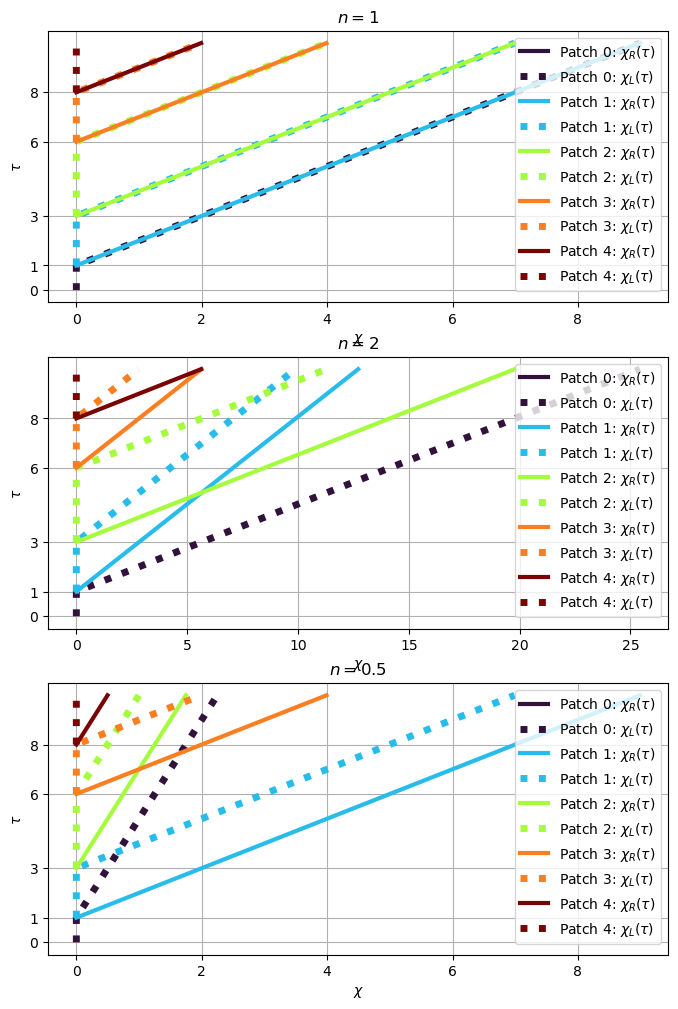

In [15]:
tau = np.arange(-1, 10, 0.01)

fig, axs = plt.subplots(len(ns))

fig.set_figheight(12)
fig.set_figwidth(8)

for ni, n in enumerate(ns):
    slp = slps[ni]

    rights = slp.get_rights(tau)
    lefts = slp.get_lefts(tau)

    for i in range(rights.shape[0]):
        axs[ni].plot(rights[i], tau, color=colors[i], 
                     linestyle='-', linewidth=3,
                     label=f"Patch {i}: $\\chi_R(\\tau)$")
        axs[ni].plot(lefts[i], tau, color=colors[i], 
                     linestyle=':', linewidth=5,
                     label=f"Patch {i}: $\\chi_L(\\tau)$")

    axs[ni].set_title(f'$n = {n}$')
    axs[ni].grid(True)
    axs[ni].legend()

    axs[ni].set_xlabel(r'$\chi$')
    axs[ni].set_ylabel(r'$\tau$')
    axs[ni].set_yticks(patch_starts)
plt.show()

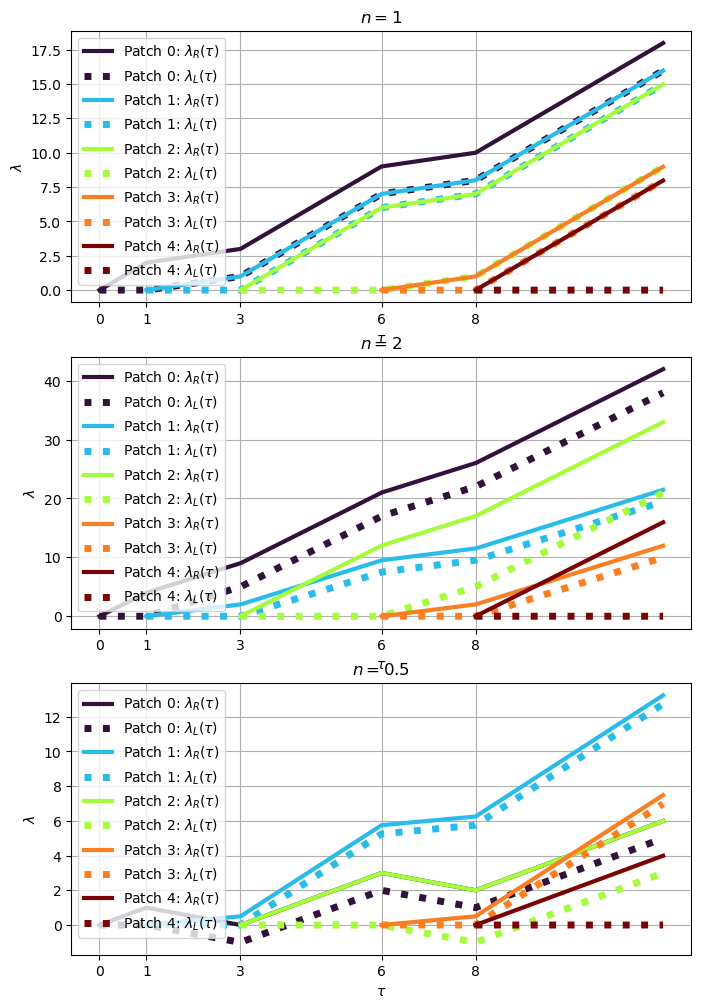

In [16]:
tau = np.arange(-1, 12, 0.01)

fig, axs = plt.subplots(len(ns))

fig.set_figheight(12)
fig.set_figwidth(8)

for ni, n in enumerate(ns):
    slp = slps[ni]

    rights = slp.get_right_elevations(tau, first_is_infinite=False)
    lefts = slp.get_left_elevations(tau)

    for i in range(rights.shape[0]):
        axs[ni].plot(tau, rights[i], color=colors[i], 
                     linestyle='-', linewidth=3,
                     label=f"Patch {i}: $\\lambda_R(\\tau)$")
        axs[ni].plot(tau, lefts[i], color=colors[i], 
                     linestyle=':', linewidth=5,
                     label=f"Patch {i}: $\\lambda_L(\\tau)$")

    axs[ni].set_title(f'$n = {n}$')
    axs[ni].grid(True)
    axs[ni].legend()

    axs[ni].set_xlabel(r'$\tau$')
    axs[ni].set_ylabel(r'$\lambda$')
    axs[ni].set_xticks(patch_starts)
plt.show()

__Warning:__ The first patches elevation take negative values when $n = 0.5$.
We also can see this on gif.

In [17]:
ntau = 121
nchi = 121

tau_max = 12
chi_max = 12

tau = np.linspace(0, tau_max, ntau).reshape([ntau, 1])*np.ones([ntau, nchi])
chi = np.linspace(0, chi_max, nchi).reshape([1, nchi])*np.ones([ntau, nchi])

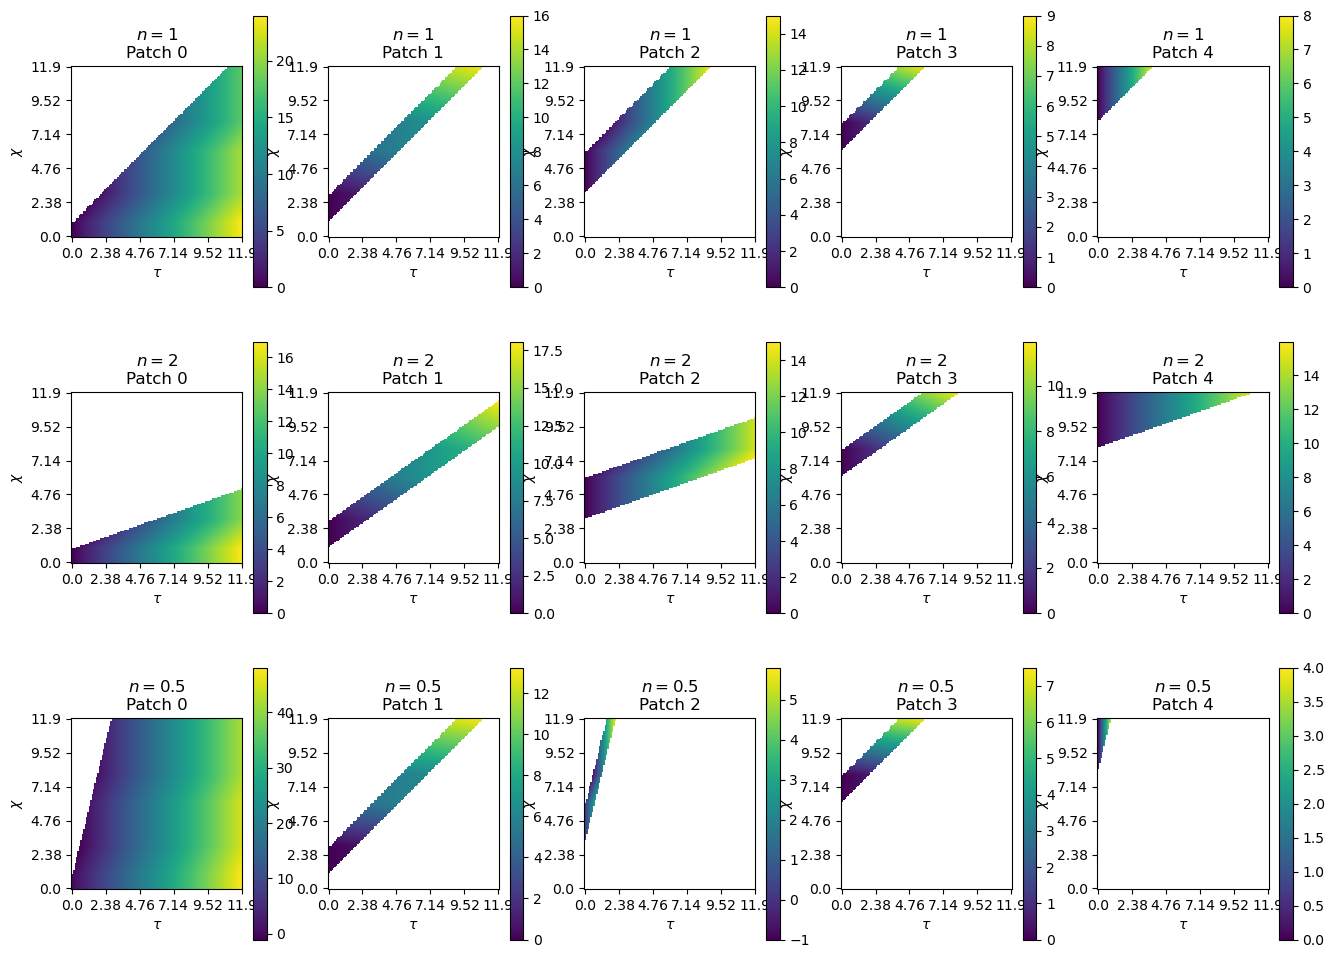

In [18]:
xticks = np.arange(0, ntau, ntau//5)
xlabels = np.round(xticks/ntau*tau_max, 2)

yticks = np.arange(0, nchi, nchi//5)
ylabels = np.round(yticks/nchi*chi_max, 2)

fig, axs = plt.subplots(len(ns), len(patch_starts))

fig.set_figwidth(16)
fig.set_figheight(12)

for ni, n in enumerate(ns):
    slp = slps[ni]
    lam = slp.get_elevations_for_patches(tau, chi)
    for i in range(slp.count()):
        axs[ni, i].set_title(f'$n = {n}$\nPatch {i}')
        im = axs[ni, i].imshow(lam[i], origin='lower')
        plt.colorbar(im, orientation='vertical')
        
        axs[ni, i].set_xlabel(r'$\tau$')
        axs[ni, i].set_ylabel(r'$\chi$')
        axs[ni, i].set_xticks(xticks, xlabels)
        axs[ni, i].set_yticks(yticks, ylabels)
        
plt.show()

/tmp/ipykernel_76356/1916483030.py:493: RuntimeWarning: invalid value encountered in divide
  chi = ((bk - bj)/(aj - ak))**((self.n - 1)/self.n)
/tmp/ipykernel_76356/1916483030.py:791: RuntimeWarning: divide by zero encountered in divide
  a = (connection_lam_right - connection_lam_left)/(connection_chi_right**k - connection_chi_left**k)
/tmp/ipykernel_76356/1916483030.py:793: RuntimeWarning: invalid value encountered in divide
  c = (patch_lam_right - patch_lam_left)/(patch_chi_right - patch_chi_left)
/tmp/ipykernel_76356/1916483030.py:806: RuntimeWarning: invalid value encountered in add
  f = lambda chi: a*(chi**k) + b - c*chi - d
/tmp/ipykernel_76356/1916483030.py:791: RuntimeWarning: divide by zero encountered in reciprocal
  a = (connection_lam_right - connection_lam_left)/(connection_chi_right**k - connection_chi_left**k)
/tmp/ipykernel_76356/1916483030.py:792: RuntimeWarning: divide by zero encountered in reciprocal
  b = connection_lam_right - a*(connection_chi_right**k)
/tmp/

chi_right.shape = (5, 121)
lam_right.shape = (5, 121)
chi_left.shape = (5, 121)
lam_left.shape = (5, 121)

patch_chi_right.shape = (5, 1, 121)
patch_lam_right.shape = (5, 1, 121)
patch_chi_left.shape = (5, 1, 121)
patch_lam_left.shape = (5, 1, 121)

connection_chi_right.shape = (1, 4, 121)
connection_lam_right.shape = (1, 4, 121)
connection_chi_left.shape = (1, 4, 121)
connection_lam_left.shape = (1, 4, 121)

a.shape = (1, 4, 121)
b.shape = (1, 4, 121)
c.shape = (5, 1, 121)
d.shape = (5, 1, 121)

chi0.shape = (5, 4, 121)
chi1.shape = (5, 4, 121)
chi_right.shape = (5, 121)
lam_right.shape = (5, 121)
chi_left.shape = (5, 121)
lam_left.shape = (5, 121)

patch_chi_right.shape = (5, 1, 121)
patch_lam_right.shape = (5, 1, 121)
patch_chi_left.shape = (5, 1, 121)
patch_lam_left.shape = (5, 1, 121)

connection_chi_right.shape = (1, 4, 121)
connection_lam_right.shape = (1, 4, 121)
connection_chi_left.shape = (1, 4, 121)
connection_lam_left.shape = (1, 4, 121)

a.shape = (1, 4, 121)
b.shape = (1,

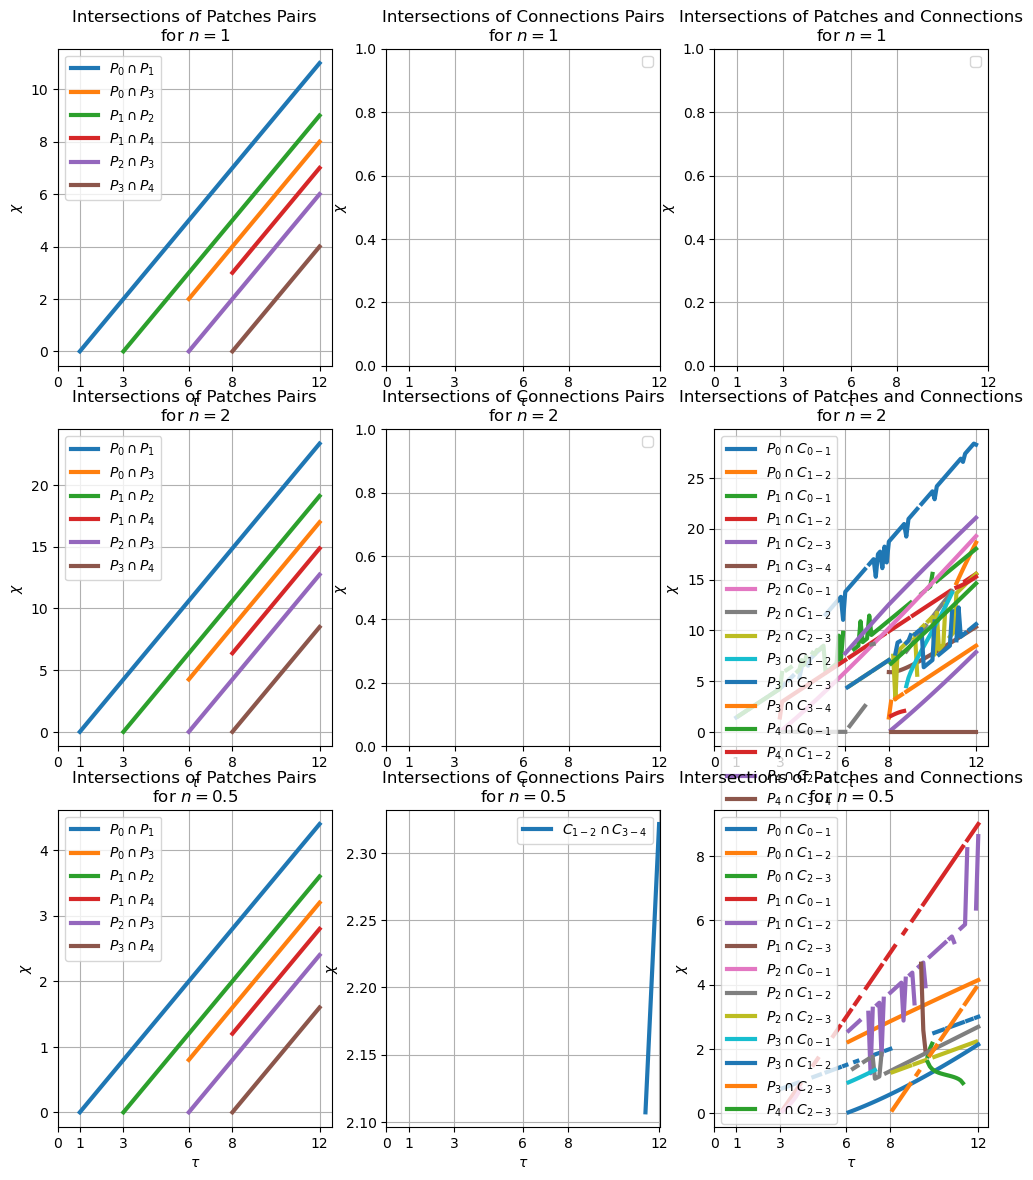

In [19]:
tau_max = 12
tau = np.linspace(0, tau_max, 121)

intersections_pp = [slp.get_intersection_matrices_of_patches(tau) for slp in slps]
intersections_cc = [slp.get_intersection_matrices_of_neighbour_connections(tau) for slp in slps]
intersections_pc = [slp.get_intersection_matrices_of_patches_and_neighbour_connections(tau) for slp in slps]


eps = 1e-6
#for m in intersections_pp:
#    assert ((m - m.transpose([1, 0, 2]) < eps)|np.isnan(m)).all()
for m in intersections_cc:
    assert ((m - m.transpose([1, 0, 2]) < eps)|np.isnan(m)).all()
    

fig, axs = plt.subplots(len(ns), 3)

fig.set_figheight(14)
fig.set_figwidth(12)

for ni, n in enumerate(ns):
    chis_pp = intersections_pp[ni]
    chis_cc = intersections_cc[ni]
    chis_pc = intersections_pc[ni]
    
    slp = slps[ni]
    N = slp.count()
    
    axs[ni, 0].set_title(f"Intersections of Patches Pairs\nfor $n = {n}$")
    axs[ni, 1].set_title(f"Intersections of Connections Pairs\nfor $n = {n}$")
    axs[ni, 2].set_title(f"Intersections of Patches and Connections\nfor $n = {n}$")
    for i in range(N):
        for j in range(i+1, N):
            if not np.isnan(chis_pp[i, j]).all():
                axs[ni, 0].plot(tau, chis_pp[i, j], linewidth=3,
                                label=f'$P_{{{i}}}\cap P_{{{j}}}$')
    for i in range(N-1):
        for j in range(i+1, N-1):
            if not np.isnan(chis_cc[i, j]).all():
                axs[ni, 1].plot(tau, chis_cc[i, j], linewidth=3,
                                label=f'$C_{{{i}-{i+1}}}\cap C_{{{j}-{j+1}}}$')
    for i in range(N):
        for j in range(N-1):
            if not np.isnan(chis_pc[i, j]).all():
                axs[ni, 2].plot(tau, chis_pc[i, j], linewidth=3,
                                label=f'$P_{{{i}}}\cap C_{{{j}-{j+1}}}$')
    for i in range(3):
        axs[ni, i].legend()
        axs[ni, i].grid(True)
        axs[ni, i].set_xlabel(r'$\tau$')
        axs[ni, i].set_ylabel(r'$\chi$')
        axs[ni, i].set_xticks(np.linspace(0, tau_max, 5))
        axs[ni, i].set_xticks(np.unique(np.concatenate([slp.patch_starts, [0, tau_max]])))
    
    
    
plt.show()

In [20]:
dtau = 0.05
dchi = 0.05

ntau = 481
nchi = 481

tau = np.arange(ntau)*dtau
chi = np.arange(nchi)*dchi

tau_space = np.ones([ntau, nchi])*tau.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chi.reshape([1, nchi])

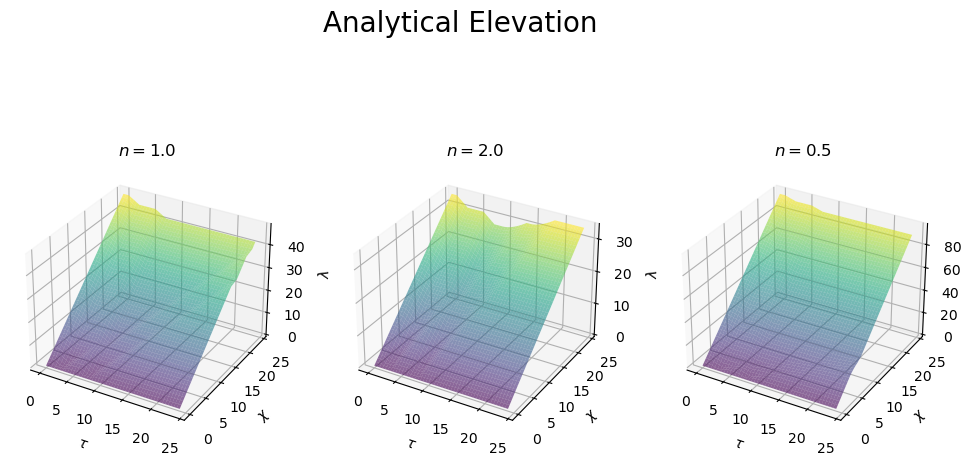

In [21]:
lams = [slp.get_elevation(tau_space, chi_space) for slp in slps]

fig, axs = plt.subplots(1, len(ns), subplot_kw={"projection": "3d"})

fig.suptitle('Analytical Elevation', fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(12)

for i, n in enumerate(ns):
    axs[i].set_title(f'$n = {n:.1f}$')
    axs[i].plot_surface(tau_space, chi_space, lams[i], alpha=0.6, cmap='viridis')
    axs[i].set_xlabel(r'$\tau$')
    axs[i].set_ylabel(r'$\chi$')
    axs[i].set_zlabel(r'$\lambda$')
plt.show()

In [22]:
# generate approximations to demo
from schemes import approx2nonlinear as scheme
import os

if not os.path.exists('approximations'):
    os.makedirs('approximations')

approximations = []
for ni, n in enumerate(ns):
    filename = f'n={n}, patch_starts={patch_starts}, uplift_rates={uplift_rates}, dtau={dtau}, ntau={ntau}, dchi={dchi}, nchi={nchi}'
    filename = f'approximations/{filename}.npy'
    try:
        with open(filename, 'rb') as file:
            approx = np.load(file)
        #raise FileNotFoundError
    except FileNotFoundError:
        nu = slps[ni].get_uplift_rate
        initial = lambda chi: chi*slps[ni].get_slopes()[0]
        border = lambda tau: tau*0

        with tqdm(total=(ntau - 1)*(nchi - 1), desc=f'Approximate the solution for n={n:.2f}') as pbar:
            approx, _tau, _chi = scheme(nu=nu, initial=initial, border=border, n=n, 
                                                  dtau=dtau, ntau=ntau, dchi=dchi, nchi=nchi, 
                                                  bar=pbar)
        with open(filename, 'wb') as file:
            np.save(file, approx)
            print(f'Approximation has been saved to path:\n{filename}')
    approximations.append(approx.copy())
        
approximations = np.array(approximations)

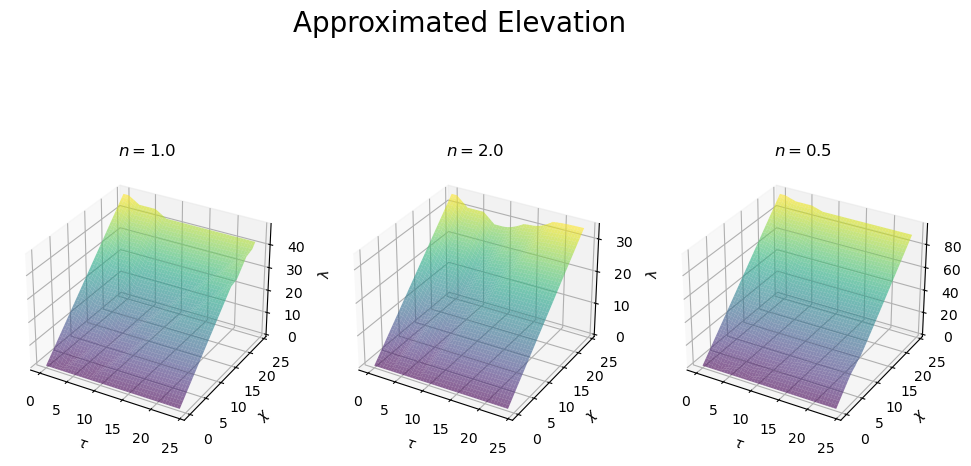

In [23]:
fig, axs = plt.subplots(1, len(ns), subplot_kw={"projection": "3d"})

fig.suptitle('Approximated Elevation', fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(12)

for i, n in enumerate(ns):
    axs[i].set_title(f'$n = {n:.1f}$')
    axs[i].plot_surface(tau_space, chi_space, approximations[i], alpha=0.6, cmap='viridis')
    axs[i].set_xlabel(r'$\tau$')
    axs[i].set_ylabel(r'$\chi$')
    axs[i].set_zlabel(r'$\lambda$')
plt.show()

# Generate Animation

In [24]:
patch_lam_spaces = np.array([slp.get_elevations_for_patches(tau_space, chi_space) for slp in slps])
conect_lam_spaces = np.array([slp.get_neighbour_connections(tau_space, chi_space) for slp in slps])

intersect_chi_lam = np.array([slp.get_neighbour_intersections(tau_space) for slp in slps])
intersect_chi = intersect_chi_lam[:, 0]
intersect_chi[intersect_chi > np.max(chi_space)] = np.nan # remove intersections, whic is out the frame
intersect_lam = intersect_chi_lam[:, 1]

left_chis = np.array([slp.get_lefts(tau_space) for slp in slps])
right_chis = np.array([slp.get_rights(tau_space) for slp in slps])
left_lams = np.array([slp.get_left_elevations(tau_space) for slp in slps])
right_lams = np.array([slp.get_right_elevations(tau_space) for slp in slps])
left_chis[left_chis > np.max(chi_space)] = np.nan
right_chis[right_chis > np.max(chi_space)] = np.nan

solution = np.array([slp.get_elevation(tau_space, chi_space) for slp in slps])

intersect_time_table = {'pp': {}, 'cc': {}, 'pc': {}}
matr_intersect_pp = []
matr_intersect_cc = []
matr_intersect_pc = []
with tqdm(total=len(slps)*3, desc='Calculating Intersections') as pbar:
    for slp in slps:
        timer = time.perf_counter()
        matr_intersect_pp.append(slp.get_intersection_matrices_of_patches(tau_space))
        intersect_time_table['pp'].update({slp.n : time.perf_counter() - timer})
        pbar.update()
        timer = time.perf_counter()
        matr_intersect_cc.append(slp.get_intersection_matrices_of_neighbour_connections(tau_space))
        intersect_time_table['cc'].update({slp.n : time.perf_counter() - timer})
        pbar.update()
        timer = time.perf_counter()
        matr_intersect_pc.append(slp.get_intersection_matrices_of_patches_and_neighbour_connections(tau_space))
        intersect_time_table['pc'].update({slp.n : time.perf_counter() - timer})
        pbar.update()
matr_intersect_pp = np.array(matr_intersect_pp) 
matr_intersect_cc = np.array(matr_intersect_cc) 
matr_intersect_pc = np.array(matr_intersect_pc) 
pd.DataFrame(intersect_time_table).transpose()

Calculating Intersections:   0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_76356/1916483030.py:493: RuntimeWarning: invalid value encountered in divide
  chi = ((bk - bj)/(aj - ak))**((self.n - 1)/self.n)


chi_right.shape = (5, 481, 481)
lam_right.shape = (5, 481, 481)
chi_left.shape = (5, 481, 481)
lam_left.shape = (5, 481, 481)

patch_chi_right.shape = (5, 1, 481, 481)
patch_lam_right.shape = (5, 1, 481, 481)
patch_chi_left.shape = (5, 1, 481, 481)
patch_lam_left.shape = (5, 1, 481, 481)

connection_chi_right.shape = (1, 4, 481, 481)
connection_lam_right.shape = (1, 4, 481, 481)
connection_chi_left.shape = (1, 4, 481, 481)
connection_lam_left.shape = (1, 4, 481, 481)

a.shape = (1, 4, 481, 481)
b.shape = (1, 4, 481, 481)
c.shape = (5, 1, 481, 481)
d.shape = (5, 1, 481, 481)

chi0.shape = (5, 4, 481, 481)
chi1.shape = (5, 4, 481, 481)


/tmp/ipykernel_76356/1916483030.py:791: RuntimeWarning: divide by zero encountered in divide
  a = (connection_lam_right - connection_lam_left)/(connection_chi_right**k - connection_chi_left**k)
/tmp/ipykernel_76356/1916483030.py:793: RuntimeWarning: invalid value encountered in divide
  c = (patch_lam_right - patch_lam_left)/(patch_chi_right - patch_chi_left)
/tmp/ipykernel_76356/1916483030.py:806: RuntimeWarning: invalid value encountered in add
  f = lambda chi: a*(chi**k) + b - c*chi - d


chi_right.shape = (5, 481, 481)
lam_right.shape = (5, 481, 481)
chi_left.shape = (5, 481, 481)
lam_left.shape = (5, 481, 481)

patch_chi_right.shape = (5, 1, 481, 481)
patch_lam_right.shape = (5, 1, 481, 481)
patch_chi_left.shape = (5, 1, 481, 481)
patch_lam_left.shape = (5, 1, 481, 481)

connection_chi_right.shape = (1, 4, 481, 481)
connection_lam_right.shape = (1, 4, 481, 481)
connection_chi_left.shape = (1, 4, 481, 481)
connection_lam_left.shape = (1, 4, 481, 481)

a.shape = (1, 4, 481, 481)
b.shape = (1, 4, 481, 481)
c.shape = (5, 1, 481, 481)
d.shape = (5, 1, 481, 481)

chi0.shape = (5, 4, 481, 481)
chi1.shape = (5, 4, 481, 481)


/tmp/ipykernel_76356/1916483030.py:791: RuntimeWarning: divide by zero encountered in reciprocal
  a = (connection_lam_right - connection_lam_left)/(connection_chi_right**k - connection_chi_left**k)
/tmp/ipykernel_76356/1916483030.py:792: RuntimeWarning: divide by zero encountered in reciprocal
  b = connection_lam_right - a*(connection_chi_right**k)
/tmp/ipykernel_76356/1916483030.py:792: RuntimeWarning: invalid value encountered in multiply
  b = connection_lam_right - a*(connection_chi_right**k)
/tmp/ipykernel_76356/1916483030.py:806: RuntimeWarning: divide by zero encountered in reciprocal
  f = lambda chi: a*(chi**k) + b - c*chi - d
/tmp/ipykernel_76356/1916483030.py:806: RuntimeWarning: invalid value encountered in multiply
  f = lambda chi: a*(chi**k) + b - c*chi - d


,1.0,2.0,0.5
pp,0.520361,0.458475,0.438605
cc,0.007726,0.215272,0.200904
pc,0.009363,14.754679,8.188339


In [25]:
frames = 181
maxlams = {2.0: 36, 
           0.5: 18}

for n in ns[1:]:
    # generate gif for only n=2, 0.5
    
    islp = np.where(np.array(ns) == n)[0][0]
    slp = slps[islp]

    maxlam = maxlams[n]

    images = []

    with tqdm(total=frames) as pbar:
        for itau in np.linspace(0, len(tau) - 1, frames).astype(int):
            tau_val = tau[itau]

            fig, ax = plt.subplots(1)
            fig.set_figwidth(12)
            fig.set_figheight(9)

            nu_val = slps[-1].get_uplift_rate(tau_val)
            fig.suptitle(f'$\\tau = {tau_val:.2f}$\n$\\nu(\\tau) = {nu_val:.2f}$')

            ax.set_title(f'$n = {slp.n:.1f}$')


            # plot approximation
            approximation = approximations[islp, itau].copy()
            approximation[approximation > maxlam] = np.nan
            ax.plot(chi, approximation, label='Approximation', color='orchid', alpha=0.25, linewidth=9)

            # plot slope patches
            lam = patch_lam_spaces[islp, :, itau, :].copy()
            lam[lam > maxlam] = np.nan
            for i, ilam in enumerate(lam):
                ax.plot(chi, ilam, label=f'Patch {i}', color=colors[i], linewidth=4, linestyle='-')

            # plot connections
            lam = conect_lam_spaces[islp, :, itau, :].copy()
            for i, ilam in enumerate(lam):
                ax.plot(chi, ilam, label=f'Connect {i}&{i+1}', 
                        color=colors[i], linewidth=4, linestyle=':')


            # plot intersections
            for i in range(slp.count() - 1):
                ax.scatter(intersect_chi[islp, i, itau], 
                           intersect_lam[islp, i, itau], 
                           label=f'Intersect {i}&{i+1}', 
                           color=colors[i], linewidths=4)

            # plot lefts and rights
            ax.scatter(left_chis[islp, :, itau], left_lams[islp, :, itau], 
                       c='grey', marker='o', label='Left borders')
            ax.scatter(right_chis[islp, :, itau], right_lams[islp, :, itau], 
                       c='grey', marker='x', label='Right borders')


            # plot analytical solution
            lam = solution[islp, itau, :]
            lam[lam > maxlam] = np.nan
            ax.plot(chi, lam, label='Analytical', color='magenta', linewidth=2, linestyle='-.')


            # plot the spatial intersections
            lam_min = patch_lam_spaces[np.invert(np.isnan(patch_lam_spaces))].min()
            lam_max = lam[np.invert(np.isnan(lam))].max()

            intersect_vals = matr_intersect_pp[islp, :, :, itau, 0]
            intersect_vals[(intersect_vals < chi.min())|(intersect_vals > chi.max())] = np.nan
            ax.scatter(intersect_vals, lam_min*np.ones(intersect_vals.shape), 
                       color='black', marker='*', label=r'Positions: $P\cap P$')
            for val in np.unique(intersect_vals):
                ax.plot(val*np.ones(2), [lam_min, lam_max], color='black', linewidth=1.5, alpha=0.6, zorder=0)

            intersect_vals = matr_intersect_cc[islp, :, :, itau, 0]
            intersect_vals[(intersect_vals < chi.min())|(intersect_vals > chi.max())] = np.nan
            ax.scatter(intersect_vals, lam_min*np.ones(intersect_vals.shape), 
                       color='goldenrod', marker='*', label=r'Positions: $C\cap C$')
            for val in np.unique(intersect_vals):
                ax.plot(val*np.ones(2), [lam_min, lam_max], color='goldenrod', linewidth=1.5, alpha=0.6, zorder=0)

            intersect_vals = matr_intersect_pc[islp, :, :, itau, 0]
            intersect_vals[(intersect_vals < chi.min())|(intersect_vals > chi.max())] = np.nan
            ax.scatter(intersect_vals, lam_min*np.ones(intersect_vals.shape), 
                       color='lime', marker='*', label=r'Positions: $P\cap C$')
            for val in np.unique(intersect_vals):
                ax.plot(val*np.ones(2), [lam_min, lam_max], color='lime', linewidth=1.5, alpha=0.6, zorder=0)
            for intersect_i in range(intersect_vals.shape[0]):
                for intersect_j in range(intersect_vals.shape[1]):
                    if not np.isnan(intersect_vals[intersect_i, intersect_j]):
                        ax.text(intersect_vals[intersect_i, intersect_j], lam_max, 
                                f'$P_{{{intersect_i}}}\cap C_{{{intersect_j}-{intersect_j+1}}}$', 
                                rotation='vertical')

            # legend and grid
            ax.legend(loc='lower right')
            ax.grid(True)
            ax.set_xlabel(r'$\chi$')
            ax.set_ylabel(r'$\lambda$')


            # draw, save, close and delete
            fig.canvas.draw()
            images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
            #plt.savefig(f'pics/patches/patches-n05-{itau:03}.png')
            plt.close('all')
            del fig

            pbar.update()

    #filename = f'gifs/patches-n={n}.gif'
    #io.mimsave(filename, images, fps=12, loop=0)
    #print(f'generated and saved to path {filename}')
    
    filename = f'gifs/patches-n={n}.mp4'
    with io.get_writer(filename, format='FFMPEG', mode='I', fps=12) as writer:
        for img in tqdm(images):
            writer.append_data(np.array(img))
    print(f'generated and saved to path {filename}')

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 900) to (1200, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


generated and saved to path gifs/patches-n=2.mp4


  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 900) to (1200, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


generated and saved to path gifs/patches-n=0.5.mp4
